In [89]:
# Welcome to the Kalshi REST v2 Starter Code!

# pypi client: recommended for more advanced programmers
import kalshi_python
from KalshiClientsBaseV2ApiKey import ExchangeClient
import time
import json
import uuid

In [90]:
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.backends import default_backend

def load_private_key_from_file(file_path):
    with open(file_path, "rb") as key_file:
        private_key = serialization.load_pem_private_key(
            key_file.read(),
            password=None,  # or provide a password if your key is encrypted
            backend=default_backend()
        )
    return private_key

In [91]:
prod_key_id = "b88d11b1-f76f-46fc-b2e7-53cba60a15f8"  # your API key ID
prod_private_key = load_private_key_from_file('/Users/matiasgomezpaz/Library/CloudStorage/GoogleDrive-gomezpaz.mat@gmail.com/My Drive/mgomezpaz/M2024/BYU/Polyshi/keys/api_key.key')  # load the private key from file

# for prod
prod_api_base = "https://api.elections.kalshi.com/trade-api/v2"

## if wanting to test in prod:
exchange_client = ExchangeClient(exchange_api_base=prod_api_base, key_id = prod_key_id, private_key = prod_private_key)

# first we will check on the exchange status to confirm you are properly connected...
print(exchange_client.get_exchange_status())

{'exchange_active': True, 'trading_active': True}


In [92]:
import requests
import pandas as pd
import json
import time

def fetch_kalshi_data(limit=200):  # Changed default to 200
    """
    Fetch all Kalshi events data using pagination
    
    Args:
        limit (int): Number of events to fetch per request (max 200)
    """
    try:
        all_events = []
        cursor = None  # Start with no cursor
        total_fetched = 0
        
        while True:
            # Construct URL based on whether this is the first request or not
            base_url = f"https://api.elections.kalshi.com/trade-api/v2/events?status=open&with_nested_markets=true&limit={limit}"
            
            if cursor:
                url = f"{base_url}&cursor={cursor}"
            else:
                url = base_url
            
            print(f"Fetching events{' with cursor: ' + cursor if cursor else '...'}")
            
            # Make request
            r = requests.get(
                url,
                headers={'accept': 'application/json'}
            )
            r.raise_for_status()  # Raise exception for bad status codes
            
            response_data = r.json()
            events_list = response_data.get('events', [])
            
            # If no events returned, we've reached the end
            if not events_list:
                print("No more events available")
                break
            
            all_events.extend(events_list)
            total_fetched += len(events_list)
            print(f"Fetched {len(events_list)} events. Total so far: {total_fetched}")
            
            # Get next cursor
            cursor = response_data.get('cursor')
            
            # If no cursor, we've reached the end
            if not cursor:
                break
                
            # Small delay to be nice to the API
            time.sleep(0.3)
        
        # Convert to DataFrame
        df = pd.DataFrame(all_events)
        
        # Remove duplicates if any
        if 'event_ticker' in df.columns:
            df = df.drop_duplicates(subset='event_ticker')
            
        print(f"\nTotal unique events fetched: {len(df)}")
        
        return df
        
    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        return pd.DataFrame()
    
# Fetch and display the data
kalshi_df = fetch_kalshi_data(limit=200)
pd.set_option('display.max_columns', None)  # Show all columns
kalshi_df.head(10)

# Save to CSV
kalshi_df.to_csv('kalshi_events.csv', index=False)

Fetching events...
Fetched 200 events. Total so far: 200
Fetching events with cursor: CgYI8LrfygYSD0tYSVZZRlVORElORy0yNg
Fetched 200 events. Total so far: 400
Fetching events with cursor: CgYI8PTUygYSEEtYV0lLSUFSVElDTEUtMjU
Fetched 200 events. Total so far: 600
Fetching events with cursor: CgYI8JD-vAYSDUtYR1JBTVNPVFktNjc
Fetched 200 events. Total so far: 800
Fetching events with cursor: CgYI8IL1uwYSDlBSRVNQQVJUWUlOLTI0
Fetched 200 events. Total so far: 1000
Fetching events with cursor: CgYI8LDVuwYSDE1BTU1BTUlBMy0yNA
Fetched 200 events. Total so far: 1200
Fetching events with cursor: CgYI8PWluwYSMEtYQ0lUSUVTV0VBVEhFUi0yNERFQzIyKEFVUykoREVOKShNSUEpKE5ZKShQSElMKQ
Fetched 68 events. Total so far: 1268

Total unique events fetched: 1268


In [93]:
def get_markets_by_categories(df, categories=['Financials', 'Economics', 'Politics']):
    """
    Filter DataFrame for specified categories
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with market data
    categories (list): List of categories to filter for
    
    Returns:
    pandas.DataFrame: Filtered DataFrame with only specified categories
    """
    # Filter for specified categories
    filtered_df = df[df['category'].isin(categories)]
    
    # Print summary of markets per category
    print("\nMarkets per category:")
    print(filtered_df['category'].value_counts())
    print("\nTotal markets:", len(filtered_df))
    
    return filtered_df

def get_active_markets(df):
    """
    Filter DataFrame for active markets
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with market data
    
    Returns:
    pandas.DataFrame: Filtered DataFrame
    """
    # Check if 'status' exists in the markets column
    def check_active_status(markets_list):
        if not isinstance(markets_list, list):
            return False
        return any(market.get('status') == 'active' for market in markets_list)
    
    # Filter for active status
    active_markets = df[df['markets'].apply(check_active_status)]
    
    return active_markets

def filter_and_analyze_markets(df, categories=None, min_volume=100000):
    """
    Filter and analyze markets based on specified criteria
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    categories (list): List of categories to filter for (default None for all categories)
    min_volume (int): Minimum volume threshold for markets
    
    Returns:
    pandas.DataFrame: Filtered and analyzed DataFrame
    """
    # Start with active markets
    filtered_df = df.copy()
    
    # Apply category filter if specified
    if categories:
        filtered_df = get_markets_by_categories(filtered_df, categories)
    
    # Filter for high volume markets and add volume columns
    high_volume_df = filtered_df[filtered_df['markets'].apply(lambda x: has_high_volume_market(x, min_volume))]
    high_volume_df['max_volume'] = high_volume_df['markets'].apply(get_max_volume)
    high_volume_df['total_volume'] = high_volume_df['markets'].apply(get_total_volume)
    
    # Sort by total volume
    high_volume_df = high_volume_df.sort_values('total_volume', ascending=False)
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total number of high volume events: {len(high_volume_df)}")
    if len(high_volume_df) > 0:
        print(f"Average total volume per event: {high_volume_df['total_volume'].mean():,.0f}")
        print(f"Median total volume per event: {high_volume_df['total_volume'].median():,.0f}")
        print(f"Maximum total volume: {high_volume_df['total_volume'].max():,.0f}")
        print(f"Minimum total volume: {high_volume_df['total_volume'].min():,.0f}")
    
    return high_volume_df

# Example usage:
categories = ['Politics', 'Science and Technology', 'Finance']  # Customize categories
min_volume = 100000  # Customize volume threshold

# Filter and analyze markets
kalshi_df = filter_and_analyze_markets(kalshi_df, categories=categories, min_volume=min_volume)

# Save results
kalshi_df.to_csv('kalshi_markets.csv', index=False)
# Display results
display_columns = ['title', 'category', 'total_volume', 'max_volume']
kalshi_df[display_columns].head(10)


Markets per category:
category
Politics                  399
Science and Technology     55
Name: count, dtype: int64

Total markets: 454

Summary Statistics:
Total number of high volume events: 81
Average total volume per event: 4,860,896
Median total volume per event: 982,325
Maximum total volume: 80,526,265
Minimum total volume: 106,161


/var/folders/bv/24mxgwm143d_rljws2fz3kmr0000gn/T/ipykernel_2625/580543806.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_volume_df['max_volume'] = high_volume_df['markets'].apply(get_max_volume)
/var/folders/bv/24mxgwm143d_rljws2fz3kmr0000gn/T/ipykernel_2625/580543806.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_volume_df['total_volume'] = high_volume_df['markets'].apply(get_total_volume)


,title,category,total_volume,max_volume
842,Who will win the popular vote?,Politics,80526265,45162113
919,Who will win the Senate race in Arizona?,Politics,32736920,21887034
628,Who will win the Popular Vote and Electoral Co...,Politics,28834915,8996112
629,"Who will win the House, Senate, and Presidency?",Politics,28214405,8285658
804,Who will win Georgia in the presidential elect...,Politics,19845336,10125412
771,Who will win Pennsylvania in the presidential ...,Politics,16964345,9047209
790,Who will win Michigan in the presidential elec...,Politics,14541613,7819510
118,Who will be Trump's Attorney General?,Politics,12390089,9882793
785,Who will win North Carolina in the presidentia...,Politics,12113748,6514228
776,Who will win Nevada in the presidential election?,Politics,10584837,5660571


In [94]:
def fetch_market_trades(ticker: str, limit: int = 1000, days_back: int = 100, save_csv: bool = True) -> pd.DataFrame:
    """
    Fetch all trades for a specific market using pagination, filtered by date
    
    Parameters:
    ticker (str): Market ticker to fetch trades for
    limit (int): Number of trades to fetch per request (max 1000)
    days_back (int): Number of days to look back from today
    save_csv (bool): Whether to save results to CSV
    
    Returns:
    pd.DataFrame: DataFrame containing all trades
    """
    base_url = "https://api.elections.kalshi.com/trade-api/v2/markets/trades"
    all_trades = []
    cursor = None
    
    # Calculate timestamp range
    max_ts = int(time.time())
    min_ts = max_ts - (days_back * 24 * 60 * 60)
    
    while True:
        params = {
            'ticker': ticker,
            'limit': limit,
            'min_ts': min_ts,
            'max_ts': max_ts
        }
        if cursor:
            params['cursor'] = cursor
            
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            
            data = response.json()
            trades = data.get('trades', [])
            
            if not trades:
                break
                
            all_trades.extend(trades)
            print(f"Fetched {len(trades)} trades. Total so far: {len(all_trades)}")
            
            cursor = data.get('cursor')
            if not cursor:
                break
                
            time.sleep(0.1)
            
        except Exception as e:
            print(f"Error fetching trades: {str(e)}")
            break
    
    # Convert to DataFrame
    trades_df = pd.DataFrame(all_trades) if all_trades else pd.DataFrame()
    
    # Save to CSV if requested
    if save_csv and not trades_df.empty:
        end_date = pd.Timestamp.now().strftime('%Y%m%d')
        start_date = (pd.Timestamp.now() - pd.Timedelta(days=days_back)).strftime('%Y%m%d')
        filename = f'kalshi_trades_{ticker}_{start_date}_to_{end_date}.csv'
        trades_df.to_csv(filename, index=False)
        print(f"\nSaved trades to: {filename}")
    
    return trades_df

# Usage example:
ticker = "POPVOTE-24-R"
trades_df = fetch_market_trades(ticker, limit=1000, days_back=100, save_csv=True)

# Print summary and display sample
print(f"\nTotal trades fetched: {len(trades_df)}")
print("\nSample of trades:")
print(trades_df.head())



Fetched 1000 trades. Total so far: 1000
Fetched 1000 trades. Total so far: 2000
Fetched 1000 trades. Total so far: 3000
Fetched 1000 trades. Total so far: 4000
Fetched 1000 trades. Total so far: 5000
Fetched 1000 trades. Total so far: 6000
Fetched 1000 trades. Total so far: 7000
Fetched 1000 trades. Total so far: 8000
Fetched 1000 trades. Total so far: 9000
Fetched 1000 trades. Total so far: 10000
Fetched 1000 trades. Total so far: 11000
Fetched 1000 trades. Total so far: 12000
Fetched 1000 trades. Total so far: 13000
Fetched 1000 trades. Total so far: 14000
Fetched 1000 trades. Total so far: 15000
Fetched 1000 trades. Total so far: 16000
Fetched 1000 trades. Total so far: 17000
Fetched 1000 trades. Total so far: 18000
Fetched 1000 trades. Total so far: 19000
Fetched 1000 trades. Total so far: 20000
Fetched 1000 trades. Total so far: 21000
Fetched 1000 trades. Total so far: 22000
Fetched 1000 trades. Total so far: 23000
Fetched 1000 trades. Total so far: 24000
Fetched 1000 trades. Tota

In [95]:
trades_df.head(10)

,trade_id,ticker,count,created_time,yes_price,no_price,taker_side
0,57d9da89-0dcb-4002-a7e8-9e4447b54eb9,POPVOTE-24-R,19,2024-12-22T05:51:08.309844Z,99,1,no
1,9fccbce4-904c-4d6d-8d24-00860c069eeb,POPVOTE-24-R,652,2024-12-22T05:49:42.340029Z,99,1,no
2,31e6fa1f-349d-4af6-b9d3-ca36d528e25a,POPVOTE-24-R,20,2024-12-21T19:47:39.41316Z,99,1,no
3,4d0d14f4-4de3-4d3b-b747-b012a151ad8b,POPVOTE-24-R,200,2024-12-21T19:00:01.571809Z,99,1,no
4,ce14bca1-2167-4400-97e2-2371131086bd,POPVOTE-24-R,19,2024-12-21T18:47:02.045585Z,99,1,no
5,135e7258-9a51-4653-bb87-761aefbe672b,POPVOTE-24-R,63,2024-12-21T15:19:51.255571Z,99,1,no
6,7880a14a-5c53-4468-8030-f4c3f42374dc,POPVOTE-24-R,57,2024-12-21T14:46:13.007571Z,99,1,no
7,fab30e17-e3cc-4145-8200-3dc90f6c9d14,POPVOTE-24-R,416,2024-12-21T01:59:49.679472Z,99,1,no
8,787f87b7-ec88-45b5-bbca-a66d6447938a,POPVOTE-24-R,11,2024-12-21T01:44:38.228695Z,99,1,no
9,56c2e06c-558a-4a34-9ef2-10cfcc27bb52,POPVOTE-24-R,15,2024-12-20T22:33:04.540704Z,99,1,no


/var/folders/bv/24mxgwm143d_rljws2fz3kmr0000gn/T/ipykernel_2625/1163492582.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.set_index('created_time').resample(resample).agg({
/var/folders/bv/24mxgwm143d_rljws2fz3kmr0000gn/T/ipykernel_2625/1163492582.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled = df.set_index('created_time').resample(resample).agg({


Plot saved as: kalshi_price_history_POPVOTE-24-R.png


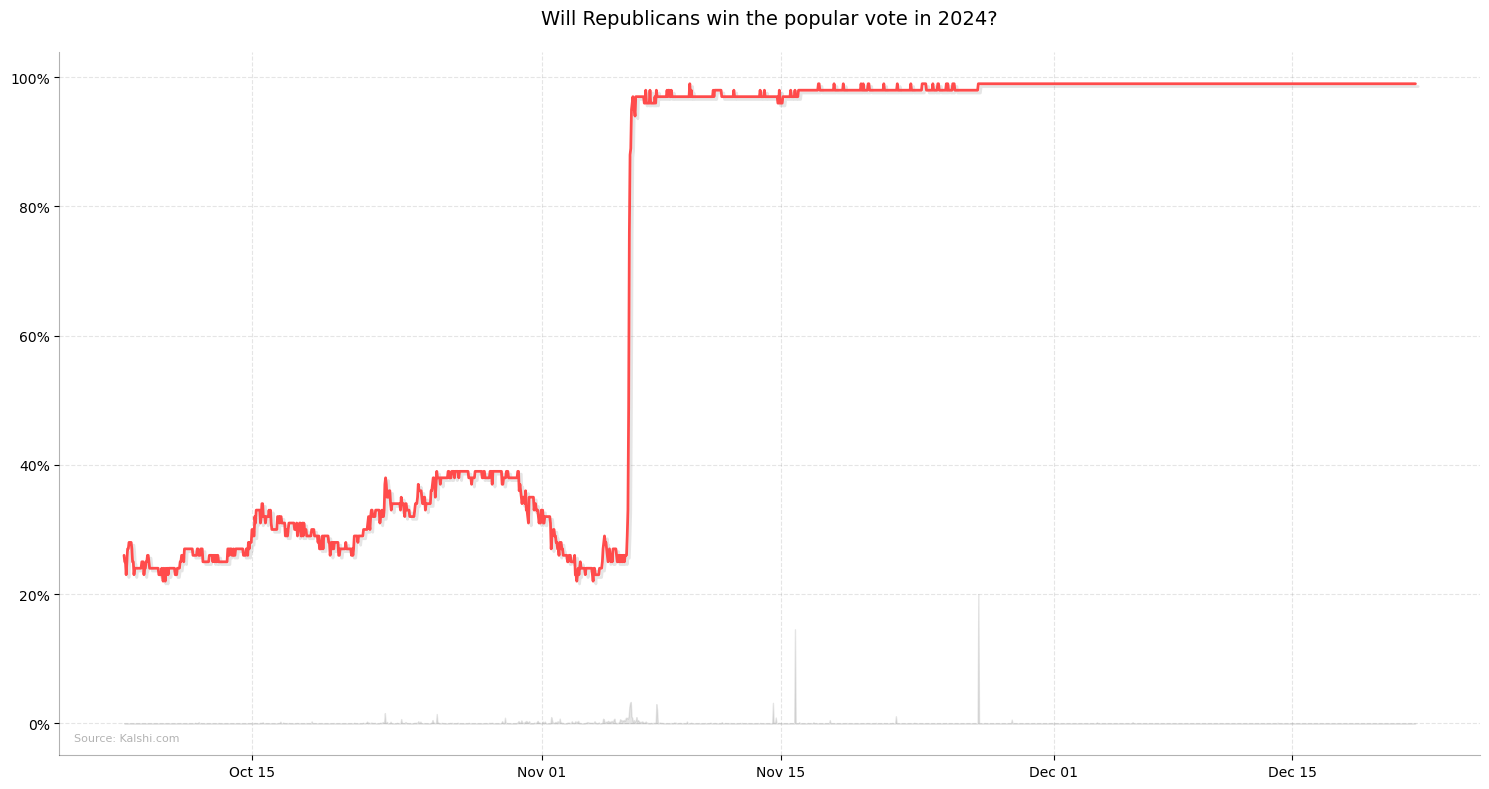

In [96]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from matplotlib.ticker import PercentFormatter

def plot_kalshi_price_history(df, title=None, resample='1H', display=True, save=True):
    """
    Plot price history for Kalshi market data
    
    Args:
        df (pd.DataFrame): DataFrame with columns: created_time, yes_price, count
        title (str): Plot title (optional)
        resample (str): Resampling frequency for smoothing ('1H' for hourly, '1D' for daily, etc.)
        display (bool): Whether to display the plot
        save (bool): Whether to save the plot
    """
    # Create figure with white background
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Ensure created_time is datetime
    df['created_time'] = pd.to_datetime(df['created_time'])
    
    # Resample data to smooth the line
    df_resampled = df.set_index('created_time').resample(resample).agg({
        'yes_price': 'last',
        'count': 'sum'
    }).fillna(method='ffill')
    
    # Plot the price line
    ax.plot(df_resampled.index, df_resampled['yes_price'] / 100,  # Convert to probability
            color='#FF4B4B',  # Kalshi red
            linewidth=2,
            solid_capstyle='round',
            path_effects=[pe.SimpleLineShadow(shadow_color='gray', alpha=0.2),
                         pe.Normal()])
    
    # Add volume bars
    volume_height = 0.2
    max_count = df_resampled['count'].max()
    ax.fill_between(df_resampled.index, 
                   0, 
                   df_resampled['count'] / max_count * volume_height,
                   alpha=0.2,
                   color='gray')
    
    # Styling
    ax.grid(True, linestyle='--', alpha=0.2, color='gray')
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Format axes
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=0)
    
    # Clean up spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.3)
    
    # Add title if provided
    if title:
        plt.title(title, pad=20, fontsize=14)
    else:
        plt.title(f"Market: {df['ticker'].iloc[0]}", pad=20, fontsize=14)
    
    # Add source
    plt.text(0.01, 0.02, 'Source: Kalshi.com', 
             transform=ax.transAxes, 
             color='gray', 
             alpha=0.6,
             fontsize=8)
    
    plt.tight_layout()
    
    # Save the plot if requested
    if save:
        filename = f'kalshi_price_history_{df["ticker"].iloc[0]}.png'
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as: {filename}")
    
    # Display the plot if requested
    if display:
        plt.show()
    else:
        plt.close()
    
    return fig

# Usage example:
# Assuming your DataFrame is called trades_df
fig = plot_kalshi_price_history(
    trades_df,
    title="Will Republicans win the popular vote in 2024?",
    resample='1H',
    display=True,  # Will show the plot
    save=True      # Will also save it
)